# Randomized Benchmarking

In this notebook we explore the subset of methods in `randomized_benchmarking.py` that are related specifically to standard randomized benchmarking. 

This includes 

- generating pyquil `Program`s that constitute a sequence of random Clifford gates.

- grouping sequences on disjoint sets of qubits into 'simultaneous' or 'parallel' RB experiments

- running these experiments on a quantum computer and isolating the relevant measurement results

- fitting an exponential decay model to the data in order to estimate the RB decay parameter

- converting the estimated RB decay parameter into an estimate of the average Clifford gate error on the given qubits


For information and examples concerning specifically interleaved RB or unitarity RB please refer to the respective dedicated notebooks in `/examples/`




## Motivation and Background

Randomized benchmarking is a commonly used protocol for characterizing an 'average performance' for gates on a quantum computer. It exhibits efficient scaling in the number of qubits overwhich the characterized gateset acts and is robust to state preparation and measurement noise. The RB decay parameter which is estimated in this procedure can be related to an estimate of 'average gate error' to the ideal, although some care is needed in interpreting this quantity; in particular note that the estimated gate error is *not* the gate infidelity averaged over the *native gateset* for our QPU. 

The main idea of the protocol is to employ random sequences of gates where the ideal composite operation of the sequence is the identity. To produce such a sequence of depth `d`, each of the first `d-1` gates in the sequence are picked uniformly at random from the Clifford group. Using the group composition and inverse property the last gate is then uniquely determined as the Clifford element which inverts the composition of the previous `d-1` gates. In the presence of noise the actual sequence of Cliffords does not enact an identity operation, and instead there is some 'survival probability' `< 1` of measuring the initial state after enacting the sequence. After estimating this 'survival probability' over many independent random sequences of increasing depth one can fit an exponential decay of the form (under some assumptions):

$$A_0 p^d + B_0$$

The parameter $p$ estimated from this fit is the RB 'decay' which can be related to the average gate error $r$ by

$$ r = 1 - p - (1 - p) / d $$

A brief summary of the procedure follows:

- Select some set of depths over which you expect the survival probability to decay significantly

- Generate many random sequences for each depth

- Estimate the 'survival probability' for each sequence by taking the fraction of outcomes matching the initial state over many shots. Here we use the `ObservablesExperiment` framework which estimates observable expectation values from which we can calculate the survival probability.

- Fit an exponential decay model to the estimated survival probabilities. 

- Extract the decay parameter from the fit and convert to 'average gate error'


Here is a starting point for more details:

[RB] Scalable and Robust Randomized Benchmarking of Quantum Processes
     Magesan et al.,
     Phys. Rev. Lett. 106, 180504 (2011)
     https://dx.doi.org/10.1103/PhysRevLett.106.180504
     https://arxiv.org/abs/1009.3639


## Diving into the code

We'll start with importing the necessary methods from the `randomized_benchmarking.py` module and setting up a demo quantum computer object to characterize along with a benchmarker object that will generate our Clifford sequences.

Since our demo is using a quantum virtual machine (QVM) you will need a qvm server. Additionally, we currently rely on a benchmarker object to generate the Clifford sequences, which requires a quilc server.

In [1]:
# Needs in terminal:
# $ quilc -S
# $ qvm -S

import numpy as np

from pyquil.api import get_benchmarker
from forest.benchmarking.randomized_benchmarking import (generate_rb_sequence,
                                                         generate_rb_experiments, acquire_rb_data,
                                                        get_stats_by_qubit_group, fit_rb_results)

%matplotlib inline

In [2]:
from pyquil.api import get_qc, get_benchmarker
qc = get_qc("9q-square-noisy-qvm")
bm = get_benchmarker()

 Let's start by generating a single sequence of 5 Clifford gates on qubit 0. (Note we won't have to actually call this individually to create a typical experiment)

In [3]:
# the results are stochastic and can be seeded with random_seed = #
sequence = generate_rb_sequence(bm, qubits=[0], depth=5)
for gate in sequence:
    print(gate) # each 'gate' is a separate pyquil Program

RX(-pi/2) 0

RZ(-pi) 0
RX(-pi) 0

RZ(pi/2) 0
RX(pi/2) 0

RX(-pi) 0

RX(pi/2) 0
RZ(pi/2) 0
RX(-pi/2) 0



Now let's start in on a full experiment on a single qubit. For the RB protocol we need to generate many sequences for many different depths, and we need to measure each sequence many times. We use the `ObservablesExperiment` framework, consistent with the rest of forest.benchmarking, to measure expectation of the `Z` observable, $E[Z]$, after running each sequence on our qubit; the survival probability will simply be $(E[Z] + 1)/2$.

Since we will use the same experiment generation for 'simultaneous' rb experiments we will need to specify our qubit as belonging to an isolated single-qubit group.

In [4]:
qubit_groups = [(2,)] # characterize the 1q gates on qubit 2
num_sequences_per_depth = 10
depths = [d for d in [2,25,50,125] for _ in range(num_sequences_per_depth)]  # specify the depth of each sequence

experiments_1q = generate_rb_experiments(bm, qubit_groups, depths)
print(experiments_1q[0])  
# shows the overall sequence being generated 
# and that we'll be initializing qubit 2 to the zero state and measuring the Z observable. 

RX(pi/2) 2; RZ(pi/2) 2; RZ(-pi/2) 2; RX(-pi/2) 2
0: Z0_2→(1+0j)*Z2


We can immediately acquire data for these experiments.

In [5]:
num_shots = 500
# run the sequences on the qc object initialized above
results_1q = acquire_rb_data(qc, experiments_1q, num_shots)
print(results_1q[0])
# shows the estimates for each observable on sequence 0
# for now there's only one observable so we get a list of lenght 1

[ExperimentResult[Z0_2→(1+0j)*Z2: 0.924 +- 0.01710111107501498]]


We can unpack the results from each `ExperimentResult` and pass this into a fit. 

In [6]:
# in this case it is simple to unpack the results--there is one result per sequence
expectations = [[res[0].expectation] for res in results_1q]
std_errs = [[res[0].std_err] for res in results_1q]

# we can also use a convenience method, which will be especially helpful with more complicated experiments
stats_q2 = get_stats_by_qubit_group(qubit_groups, results_1q)[(2,)]

# demonstrate equivalence
np.testing.assert_array_equal(expectations, stats_q2['expectation'])
np.testing.assert_array_equal(std_errs, stats_q2['std_err'])

# fit the exponential decay model
fit_1q = fit_rb_results(depths, expectations, std_errs, num_shots)

This fit contains estimates for the rb decay from which we can get the gate error.

We can also plot a figure 

0.9983642178487215


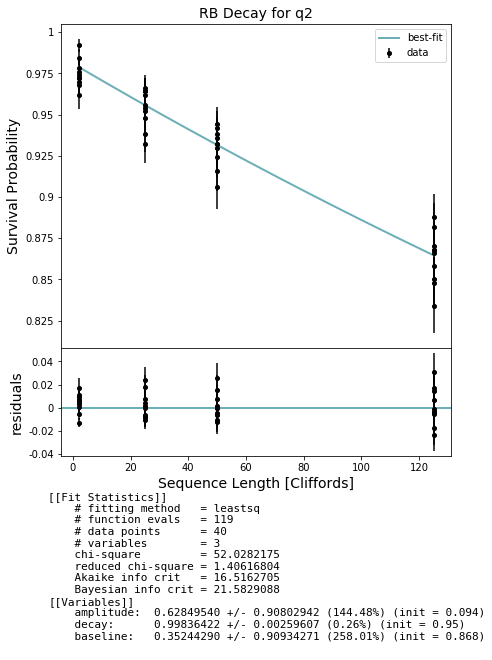

In [11]:
from forest.benchmarking.plotting import plot_figure_for_fit

fig, ax = plot_figure_for_fit(fit_1q, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability", title='RB Decay for q2')
rb_decay_q2 = fit_1q.params['decay'].value
print(rb_decay_q2)

## Simultaneous RB

Running simultaneous experiments and multi-qubit experiments follows the same work flow. Here we'll demonstrate a 1q-simultnaeous experiment. 'Simultaneous' has to be qualified somewhat on a real QPU -- the physical action of gates is not gauranteed to occur in the order specified by a quil program (only the causal relationships). Further one sequence of gates may terminate before another 'simultaneous' sequence has. Measurement only occurs when all gates have executed. 

## Generate a 2 qubit RB experiment

In [ ]:
num_sequences_per_depth = 10
depths = 3 * 2 ** np.arange(3, dtype=np.uint8)
depths = [d for d in depths for _ in range(num_sequences_per_depth)]

expts = generate_rb_experiments(bm, [(0, 2)], depths)

## Run a single 2-qubit RB experiment on a QuantumComputer

In [ ]:
expt_results = acquire_rb_data(qc, expts, num_shots=100)

In [ ]:
expt_results[0]

## Generate and run a simultaneous rb experiment on qubit 1 and qubits (0, 2)

In [ ]:
qubits = [(1,), (0,2)]
simult_expts = generate_rb_experiments(bm, qubits, depths)

In [ ]:
num_shots = 100
simult_results = acquire_rb_data(qc, simult_expts, num_shots=num_shots)

## Organize the expectations and std_errs by qubit group (1,) and (0,2)

In [ ]:
stats_by_group = get_stats_by_qubit_group(qubits, simult_results)
assert len(stats_by_group[(1,)]['expectation']) == len(depths)

## Fit the data separately for each group and plot.

In [ ]:
from forest.benchmarking.analysis.fitting import make_figure
group = qubits[0]
stats = stats_by_group[group]
exps = stats['expectation']
std_errs = stats['std_err']

fit = fit_rb_results(depths, exps, std_errs)
fig, axs = make_figure(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability")
rb_decay = fit.params['decay']

In [ ]:
group = qubits[1]
stats = stats_by_group[group]
exps = stats['expectation']
std_errs = stats['std_err']

fit = fit_rb_results(depths, exps, std_errs, num_shots)
fig, axs = make_figure(fit, xlabel="Sequence Length [Cliffords]", ylabel="Survival Probability")
rb_decay = fit.params['decay']

## Simultaneous unitarity

In [ ]:
num_sequences = 10
depths = 3 * 2 ** np.arange(3, dtype=np.uint8)
depths = [d for d in depths for _ in range(num_sequences_per_depth)]
qubits = [(1,), (5,)]

uexpts = generate_unitarity_experiments(bm, qubits, depths)
print(uexpts[0])
simult_u_results = acquire_rb_data(qc, uexpts, num_shots=100)

In [ ]:
from forest.benchmarking.analysis.fitting import make_figure
stats_by_group = get_stats_by_qubit_group(qubits, simult_u_results)

group = qubits[0]
stats = stats_by_group[group]
exps = stats['expectation']
std_errs = stats['std_err']

fit = fit_unitarity_results(depths, exps, std_errs)
fig, axs = make_figure(fit, xlabel="Sequence Length [Cliffords]", ylabel="Shifted Purity")
unitarity = fit.params['decay'].value

In [ ]:
group = qubits[1]
stats = stats_by_group[group]
exps = stats['expectation']
std_errs = stats['std_err']

fit = fit_unitarity_results(depths, exps, std_errs)
fig, axs = make_figure(fit, xlabel="Sequence Length [Cliffords]", ylabel="Shifted Purity")
unitarity = fit.params['decay'].value